In [1]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle

import utils as u
from models import Poisson_Model_T, Poisson_Model, LongTerm_Model
%matplotlib inline


%load_ext autoreload
%autoreload 2

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
data = pd.read_csv('../data/gp_weekly_nta_data.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

data.DATE_IND = data.DATE_IND.astype(float)  # try to bring down variance scale

data.rename(columns={'INJURED':'COUNT'},inplace=True)

data.COUNT = data.COUNT.astype(float)

#data = data[data.BoroName == 'Manhattan']



In [5]:
e_s = ((769 / 100000) * 8500000) / 52

In [6]:
city_data = data.groupby('DATETIME')[['COUNT']].sum()
city_data['DATE_IND'] = range(0,city_data.shape[0]) 
city_data['DATE_IND'] += 1
city_data.DATE_IND = city_data.DATE_IND.astype(float) / 100
#city_data.DATE_IND = (city_data.DATE_IND - city_data.DATE_IND.mean()) / city_data.DATE_IND.std()
city_data = city_data.iloc[2:] # drop first week
city_data.reset_index(inplace = True)
city_data.head()

,DATETIME,COUNT,DATE_IND
0,2012-07-15,827.0,0.03
1,2012-07-22,838.0,0.04
2,2012-07-29,802.0,0.05
3,2012-08-05,792.0,0.06
4,2012-08-12,836.0,0.07


In [7]:
search_periods = [[156,52]]
                 

In [48]:
for i, s in enumerate(search_periods):
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(city_data, start_date= '2012/07/15', training_end_date= s[0], \
                                                           testing_end_date=s[1], time_only = True)


    m = LongTerm_Model(data_dict['X_train'],data_dict['y_train'],use_priors=True, e_s= e_s , period = 1)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 20000)
    
    #u.pred_GP(m,data_dict)
    #test = data_dict['test']

    #gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    #ar = u.run_AR(data_dict)
    #summary = pd.concat([gp,ar],axis=1)
    #summary.plot()

    #print(summary.mean())


Beginning run [156, 52] : 
Training ends on: 2015-07-12 00:00:00
testing ends on: 2016-07-10 00:00:00
Initial neg. log-likelihood: -713329.498877
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1180.225107
  Number of iterations: 4520
  Number of functions evaluations: 4879


added gp pred and error to test


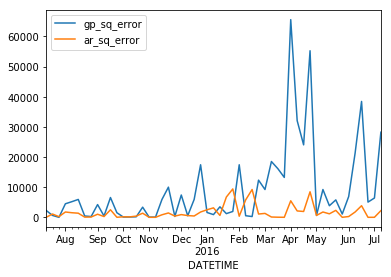

In [49]:
ar = u.run_AR(data_dict, group_by=None)

ar_se = pd.Series(np.square(ar))
#np.square(ar).mean()

u.pred_GP(m,data_dict)

se = data_dict['test'][['gp_sq_error']].copy()
se['ar_sq_error'] = ar_se.values
se.plot()

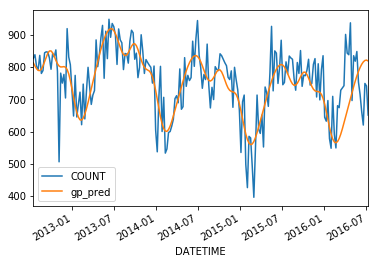

In [50]:
pred_train = m.predict_y(data_dict['X_train'])
pred_test = m.predict_y(data_dict['X_test'])

train = data_dict['train']
train['gp_pred'] = pred_train[0]
test = data_dict['test']
test['gp_pred'] = pred_test[0]
test['gp_var'] = pred_test[1]


train.append(test)[['COUNT','gp_pred']].plot()


## This needs:
# train/test normalization has to be split
# prediction has to be done right when looking ahead (sequentially)


In [51]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/q_mu,Parameter,None,(none),True,"(157, 1)",True,"[[-0.598952507088], [-0.440622155319], [0.0559..."
VGP/kern/rbf/variance,Parameter,"student-T([ 0.],[ 1.][ 4.])",+ve,True,(),True,0.5004571736191552
VGP/kern/rbf/lengthscales,Parameter,"student-T([ 0.],[ 1.][ 4.])",+ve,True,(),True,0.9286417431531693
VGP/kern/periodic/lengthscales,Parameter,"student-T([ 0.],[ 1.][ 4.])",+ve,True,(),True,0.4025133746664908
VGP/kern/periodic/period,Parameter,None,+ve,True,(),True,0.5274162411542065
VGP/kern/periodic/variance,Parameter,"student-T([ 0.],[ 1.][ 4.])",+ve,True,(),True,0.029322232962549367
VGP/kern/linear/variance,Parameter,"student-T([ 0.],[ 1.][ 4.])",+ve,True,(),True,0.5539832336806731
VGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 157, 157)",True,"[[[0.0205586374871, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."


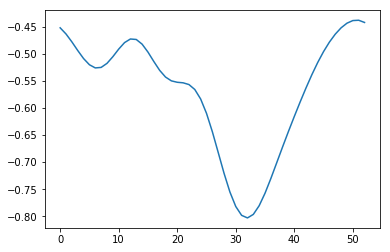

In [75]:
f = m.predict_f(data_dict['X_test'])
plt.plot(f[0])

In [70]:
m.

(array([[-0.45178067],
        [-0.46317833],
        [-0.47775523],
        [-0.49367517],
        [-0.50859417],
        [-0.52002976],
        [-0.5258718 ],
        [-0.52494194],
        [-0.51744754],
        [-0.50515123],
        [-0.49112561],
        [-0.47908374],
        [-0.47243185],
        [-0.47331578],
        [-0.48197222],
        [-0.49662619],
        [-0.51401189],
        [-0.53038853],
        [-0.5427427 ],
        [-0.54978487],
        [-0.55239923],
        [-0.55338774],
        [-0.55659791],
        [-0.56573899],
        [-0.58328387],
        [-0.60978705],
        [-0.64376546],
        [-0.6820828 ],
        [-0.72064299],
        [-0.75517412],
        [-0.78194173],
        [-0.79830414],
        [-0.80306181],
        [-0.79655541],
        [-0.78047448],
        [-0.75738847],
        [-0.73010513],
        [-0.70104676],
        [-0.67184946],
        [-0.64330492],
        [-0.61561318],
        [-0.5887781 ],
        [-0.56293351],
        [-0

In [150]:

output = pd.DataFrame(index=test.index, columns=['pred','seed'])

output.ix[0,'seed'] = m.predict_f([data_dict['X_train'][-1]])[0]

for i in range(output.shape[0]):
    output.ix[i+1,'pred'] = m.predict_y([output.ix[0,'seed'][0]])


                                       
    if i > 0:
        m.predict_f([output.ix[i,'seed']])[0]

output


[nan]


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


ValueError: Cannot feed value of shape (1,) for Tensor 'autoflow/VGP/predict_f/Placeholder:0', which has shape '(?, ?)'

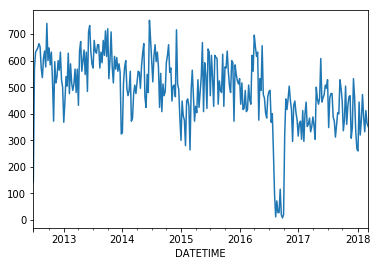

In [14]:
## Missing data 2016

data.groupby('DATETIME')['COUNT'].sum().plot()

In [ ]:
test.groupby('GRID_SQUARE')['COUNT'].sum().sort_values(ascending = False).head()

In [ ]:
test[test.GRID_SQUARE == 108][['gp_pred','COUNT']].plot()